In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date    3650 non-null datetime64[ns]
Temp    3650 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date           3650 non-null datetime64[ns]
Temperature    3650 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB
None

        date  min_temp  max_temp
0 1981-01-01      20.7      38.1
1 1981-01-02      17.9      32.4
2 1981-01-03      18.8      34.5
3 1981-01-04      14.6      20.7
4 1981-01-05      15.8      21.5

Minimum / Maximum average temperatures: 11.178 / 20.009151
Minimum / Maximum temperature standard deviations: 4.072 / 6.108353

Standard deviation by year
      min_temp  max_temp
year                    
1981  4.337430  6.581775
1982  4.806858  6.894386
1983  4.187325  6.315571
1984  3.733946  5.503548
1985

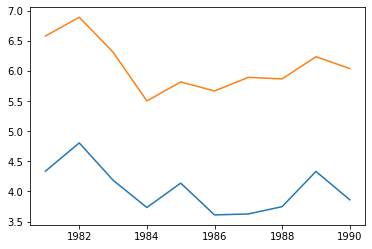

In [2]:
# open and combine datasets
min_temp_df = pd.read_csv('tmp/daily-min-temperatures.csv')
max_temp_df = pd.read_csv('tmp/daily-max-temperatures.csv')

min_temp_df['Date'] = pd.to_datetime(min_temp_df['Date'], errors = 'coerce')
max_temp_df['Date'] = pd.to_datetime(max_temp_df['Date'], errors = 'coerce')

print(min_temp_df.info())
print()
print(max_temp_df.info())
print()
temp_df = min_temp_df.merge(max_temp_df)
temp_df.columns = ['date', 'min_temp', 'max_temp']
print(temp_df.head())
print()

# checkout the data
print('Minimum / Maximum average temperatures: {:.3f} / {:3f}'
      .format(temp_df['min_temp'].mean(), temp_df['max_temp'].mean()))

# standard deviation of maximum temperatures are much higher
# expect higher errors in max temperature predictions
print('Minimum / Maximum temperature standard deviations: {:.3f} / {:3f}'
      .format(temp_df['min_temp'].std(), temp_df['max_temp'].std()))

print()
temp_df['year'] = temp_df['date'].apply(lambda x: x.year)
grouped_df = temp_df.groupby('year').agg({'min_temp': np.std, 'max_temp': np.std})
print('Standard deviation by year')
print(grouped_df)
plt.plot(grouped_df)

In [3]:
columns = ['min_temp', 'max_temp']
time = temp_df['date'].to_numpy()
series = temp_df[columns].to_numpy().astype(float)
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
print(x_train.shape)
print(x_valid.shape)

(2500, 2)
(1150, 2)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # No need to expand dims in multivariate
    # series_dim is greater than one so python will not create rank-1 array
    # Before we had to change the (2500,) array to (2500,1) array
    # Since we start with more than one feature, we'll already have (2500,2)
    #series = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1:]))
    return dataset.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 25
batch_size = 50
series_dim = len(columns)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 50, kernel_size = 5, strides = 1, padding = 'causal', 
                           activation = 'relu', input_shape = [window_size, series_dim]),
    #tf.keras.layers.MaxPooling1D(2, 2),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.LSTM(50, return_sequences = True),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(25, activation = 'relu'),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Lambda(lambda x: x * 100)
])
model.summary()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 2), (None, None, 2)), types: (tf.float64, tf.float64)>
(2500, 2)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 50)            550       
_________________________________________________________________
lstm (LSTM)                  (None, 25, 50)            20200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 50)            20200     
_________________________________________________________________
dense (Dense)                (None, 25, 50)            2550      
_________________________________________________________________
dense_1 (Dense)              (None, 25, 25)            1275      
________________________________________________________

50/50 [==============================] - 2s 30ms/step - loss: 2.6296 - mae: 3.0855
Epoch 69/100
50/50 [==============================] - 1s 30ms/step - loss: 2.6267 - mae: 3.0825
Epoch 70/100
50/50 [==============================] - 2s 31ms/step - loss: 2.6269 - mae: 3.0826
Epoch 71/100
50/50 [==============================] - 2s 31ms/step - loss: 2.6260 - mae: 3.0814
Epoch 72/100
50/50 [==============================] - 2s 30ms/step - loss: 2.6322 - mae: 3.0872
Epoch 73/100
50/50 [==============================] - 2s 31ms/step - loss: 2.6386 - mae: 3.0941
Epoch 74/100
50/50 [==============================] - 2s 30ms/step - loss: 2.6332 - mae: 3.0893
Epoch 75/100
50/50 [==============================] - 2s 30ms/step - loss: 2.6072 - mae: 3.0628
Epoch 76/100
50/50 [==============================] - 2s 30ms/step - loss: 2.5844 - mae: 3.0393
Epoch 77/100
50/50 [==============================] - 2s 31ms/step - loss: 2.5839 - mae: 3.0380
Epoch 78/100
50/50 [==============================] -

[1e-08, 0.0001, 0, 60]

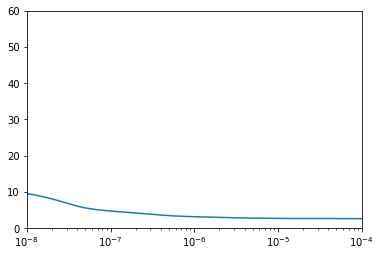

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=25, batch_size=50, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 50, kernel_size = 5, strides = 1, padding = 'causal', 
                           activation = 'relu', input_shape = [window_size, series_dim]),
    #tf.keras.layers.MaxPooling1D(2, 2),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.LSTM(50, return_sequences = True),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(25, activation = 'relu'),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Lambda(lambda x: x * 100)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
50/50 [==============================] - 3s 64ms/step - loss: 3.5385 - mae: 4.0111
Epoch 2/150
50/50 [==============================] - 2s 31ms/step - loss: 2.7082 - mae: 3.1651
Epoch 3/150
50/50 [==============================] - 2s 31ms/step - loss: 2.6759 - mae: 3.1309
Epoch 4/150
50/50 [==============================] - 2s 31ms/step - loss: 2.6489 - mae: 3.1034
Epoch 5/150
50/50 [==============================] - 2s 31ms/step - loss: 2.6428 - mae: 3.0970
Epoch 6/150
50/50 [==============================] - 2s 31ms/step - loss: 2.6340 - mae: 3.0881
Epoch 7/150
50/50 [==============================] - 2s 31ms/step - loss: 2.6145 - mae: 3.0692
Epoch 8/150
50/50 [==============================] - 2s 31ms/step - loss: 2.5969 - mae: 3.0521
Epoch 9/150
50/50 [==============================] - 2s 30ms/step - loss: 2.5924 - mae: 3.0477
Epoch 10/150
50/50 [==============================] - 2s 30ms/step - loss: 2.5842 - mae: 3.0392
Epoch 11/150
50/50 [=============================

50/50 [==============================] - 2s 31ms/step - loss: 2.4821 - mae: 2.9345
Epoch 87/150
50/50 [==============================] - 2s 30ms/step - loss: 2.4816 - mae: 2.9340
Epoch 88/150
50/50 [==============================] - 2s 30ms/step - loss: 2.4811 - mae: 2.9334
Epoch 89/150
50/50 [==============================] - 2s 31ms/step - loss: 2.4805 - mae: 2.9329
Epoch 90/150
50/50 [==============================] - 2s 31ms/step - loss: 2.4802 - mae: 2.9325
Epoch 91/150
50/50 [==============================] - 2s 31ms/step - loss: 2.4798 - mae: 2.9321
Epoch 92/150
50/50 [==============================] - 2s 31ms/step - loss: 2.4792 - mae: 2.9316
Epoch 93/150
50/50 [==============================] - 2s 30ms/step - loss: 2.4788 - mae: 2.9311
Epoch 94/150
50/50 [==============================] - 2s 30ms/step - loss: 2.4783 - mae: 2.9307
Epoch 95/150
50/50 [==============================] - 2s 31ms/step - loss: 2.4779 - mae: 2.9303
Epoch 96/150
50/50 [==============================] -

(1150, 2)


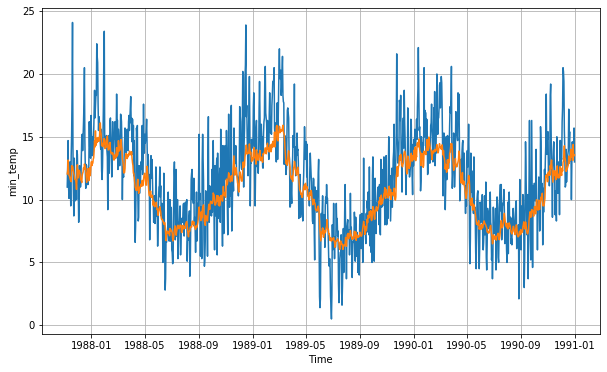

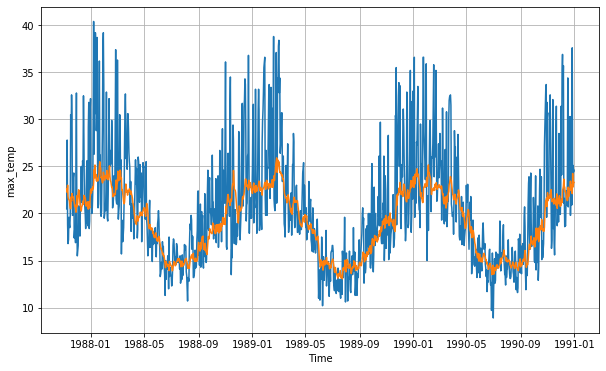

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def plot_series(time, series, ylabel = 'Value', format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.grid(True)

rnn_forecast = model_forecast(model, series, window_size)
# get slice of timsteps for validation (a window before split time to the end)
# get last timestep in the window with -1
# get both columns with :
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, :]
print(rnn_forecast.shape)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:, 0])
plot_series(time_valid, rnn_forecast[:, 0], columns[0])

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:, 1])
plot_series(time_valid, rnn_forecast[:, 1], columns[1])

In [11]:
min_temp_mae = tf.keras.metrics.mean_absolute_error(x_valid[:, 0], rnn_forecast[:, 0]).numpy()
max_temp_mae = tf.keras.metrics.mean_absolute_error(x_valid[:, 1], rnn_forecast[:, 1]).numpy()
temp_mae = (tf.keras.metrics.mean_absolute_error(
    np.vstack((x_valid[:, 0], x_valid[:, 1])).flatten(), 
    np.vstack((rnn_forecast[:, 0], rnn_forecast[:, 1])).flatten()
).numpy())
print('min_temp_mae {:.3f}'.format(min_temp_mae))
print('max_temp_mae {:.3f}'.format(max_temp_mae))
print('temp_mae {:.3f}'.format(temp_mae))

min_temp_mae 1.986
max_temp_mae 3.202
temp_mae 2.594
